# Linear Regression explain

In [2]:
%load_ext autoreload
%autoreload 2
%pylab inline

from collections import defaultdict, OrderedDict, Counter
import copy
import numpy as np
import pandas as pd
from pprint import pprint
import matplotlib.pyplot as plt
from datetime import date, datetime
import os

Populating the interactive namespace from numpy and matplotlib


# Load and prepare data

In [73]:
df_train = pd.read_csv("data/data_clean_train.csv")

def xy_split(df):
    feature_names = ['Year']
    df_x = df[feature_names]
    x = df_x.values.astype(np.float32)
    
    s_y = df['MSRP']
    y = s_y.values.astype(np.float32)
    y = np.expand_dims(y, axis=1)  # For easier matrix multiplication
    
    return x, y, feature_names

x_train_raw, y_train_raw, feature_names = xy_split(df_train)

print(x_train_raw.shape)
print(y_train_raw.shape)

(7144, 1)
(7144, 1)


# Predikce

$$
\hat{y} = w_0 + w_1 x_1 + ... + w_n x_n
$$

- $\hat{y}$ ... predikce 
- $w_i$ ... váhy modelu
- $x_i$ ... features
- $n$ ... počet features


$$\hat{y}^{(i)} = w_0 x_0^{(i)} + w_1 x_1^{(i)} + ... + w_n x_n^{(i)}$$

 - zavedení empty features $x_0=1$
 - upraveno pro $i$-tý example
 
$$\hat{Y} = X W$$

- $\hat{Y} \in R^{m}$ vektor predickcí
- $Y \in R^{m}$ trainset targets
- $m$ ... počet examplů
- $X \in R^{mx(n+1)} $ trainset features
- $W \in R^{n+1} $ parametry modelu

In [74]:
scaler = StandardScaler()

def preprocess(x, y, scaler, is_train):
    
    # Scale    
    if is_train:
        scaler.fit(x)
        
    x = scaler.transform(x)

    # Add empty features
    nr_examples = x.shape[0]
    x0 = np.ones([nr_examples, 1])
    x = np.hstack([x0, x])
    
    return x, y

x_train, y_train = preprocess(x_train_raw, y_train_raw, scaler, is_train=True)
x_train.shape

(7144, 2)

In [261]:
def predict(x, w):
    return x @ w

# Loss funkce

\begin{equation}
\begin{split}
J  = & \frac{1}{m} \sum_{i=1}^{m}(\hat{y}^{(i)} - y^{(i)})^2 \\
= &\frac{1}{m} \sum_{i=1}^{m}(w_0 x_0^{(i)} + ... + w_n x_n^{(i)} - y^{(i)})^2 \\
= & \frac{1}{m} (\hat{Y}-Y)^T(\hat{Y}-Y) 
\end{split}
\end{equation}

- Co nám loss funkce říká?
- Chceme ji co nejmenší/největší?
- Co jsou parametry funkce?
- Jak ji můžeme zmenšit?

In [262]:
def loss(x, y, w):
    nr_examples = x.shape[0] 
    
    y_pred = predict(x, w)
    err = y_pred - y
    J = err.T @ err / nr_examples
    J = np.asscalar(J)
    return J

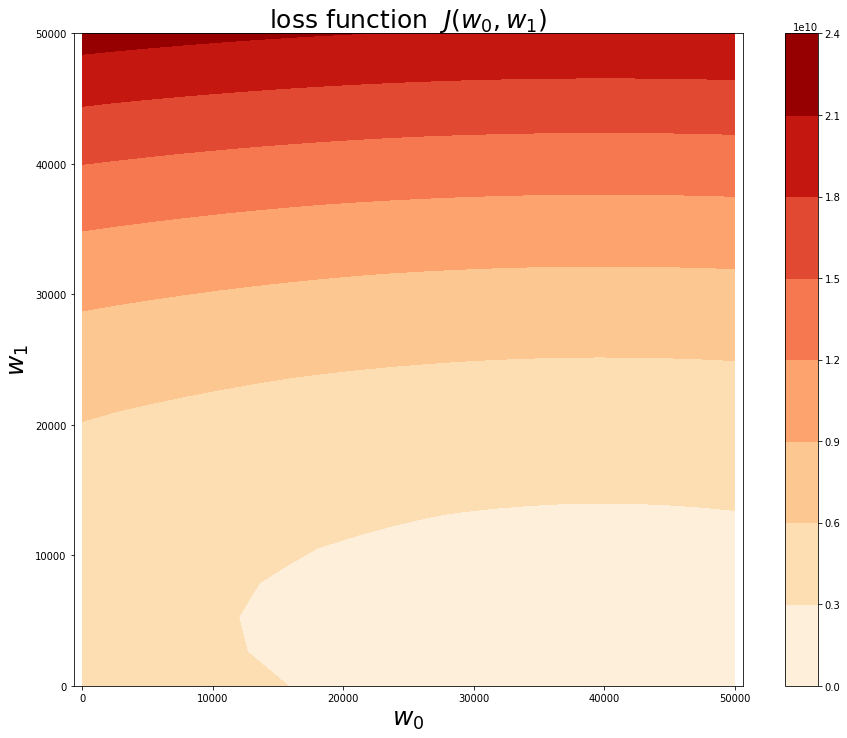

In [263]:
import matplotlib.pyplot as plt
# import colormaps as cmaps
from matplotlib import cm
plt.rcParams["figure.figsize"] = (15,12)
fontsize = 25

def plot_loss(x, y, start=0, end=50000):
    nr_examples = x.shape[0]
    
    N = 20
    w0_arr = np.linspace(start, end, N)
    w1_arr = np.linspace(start, end, N)

    W0, W1 = np.meshgrid(w0_arr, w1_arr)
    
    Z = np.zeros(W1.shape)
    for i_w0, w0 in enumerate(w0_arr):
        for i_w1, w1 in enumerate(w1_arr):
            w = np.array([[w0, w1]]).T  # column vector
            Z[i_w1, i_w0] = loss(x, y, w)
            
    fig, ax = plt.subplots()
    cs = plt.contourf(W0, W1, Z, cmap=cm.OrRd)
    cbar = fig.colorbar(cs)
    plt.axis('equal')
    plt.xlabel("$w_0$", size=fontsize)
    plt.ylabel("$w_1$", size=fontsize)
    plt.title("loss function  $J(w_0, w_1)$", size=fontsize)
    
    return fig, ax

fig, ax = plot_loss(x_train, y_train)

- Pro jaký dataset je funkce?
- Kde v grafu najdu model?
- Co se změní pokud:
  - Přidáme train examples
  - Vykreslíme devset
  - Přidáme features
- Co je za problém s kreslením grafu

# Gradient

In [156]:
def grad(x, y, w):
    nr_examples = x.shape[0]
    y_predict = predict(x, w)
    err = y_predict - y
    return 2 / nr_examples * (x.T @ err)

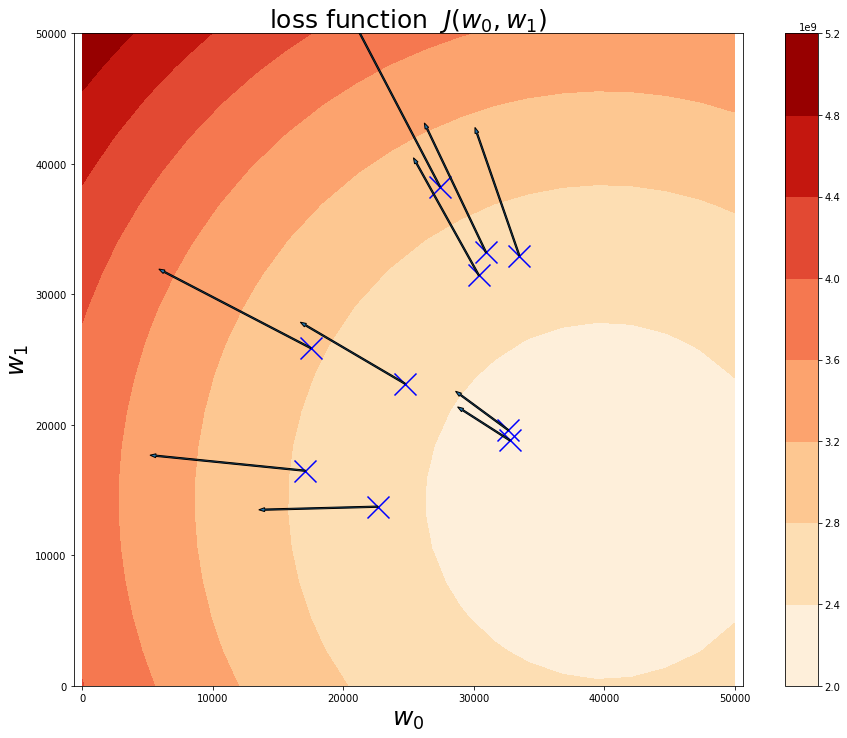

In [321]:
fig, ax = plot_loss(x_train, y_train)

for i in range(10):
    # get and plot random model
    w = np.random.rand(2, 1) * 30000 + 12000
    
    ax.scatter(*w, marker="x", color="b", s=22**2)

    # gradient
    w_grad = grad(x_train, y_train, w)
    ax.arrow(*w.ravel(), *w_grad.ravel()/4, width=100)

$$\nabla J = \left[ \frac{\partial J}{\partial w_0}, \frac{\partial J}{\partial w_1} \right] ^T$$

Odvození:
\begin{equation}
\begin{split}
                              J & = & \frac{1}{m} \sum_{i=1}^{m}(w_0 x_0^{(i)} + ... + w_n x_n^{(i)} - y^{(i)})^2 \\
\frac{\partial J}{\partial w_j} & = & \frac{2}{m} \sum_{i=1}^{m} \left( \hat{y}^{(i)} - y^{(i)} \right) x_j^{(i)}
\end{split}
\end{equation}


Vektorový zápis:

$$
\nabla J(w_i) = \frac{2}{m}  X^T \left( \hat{Y} - Y \right)
$$

# Gradinet descent
- algoritmus pro hledání minima loss funkce J
- inicializace $w$ náhodně
- jdeme ve proti směru gradientu

(0, 4101498536.8855386)

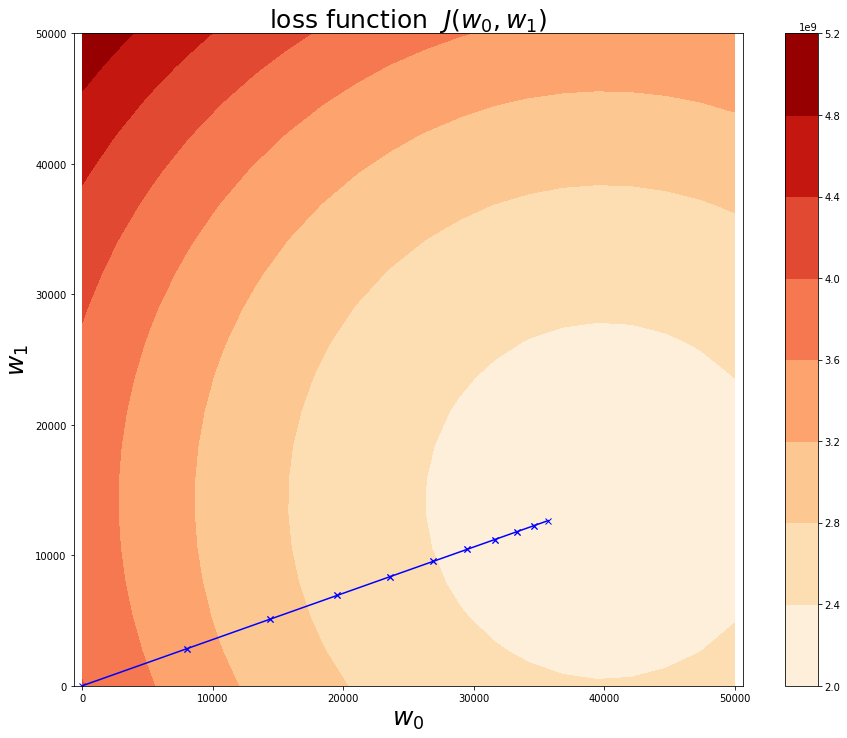

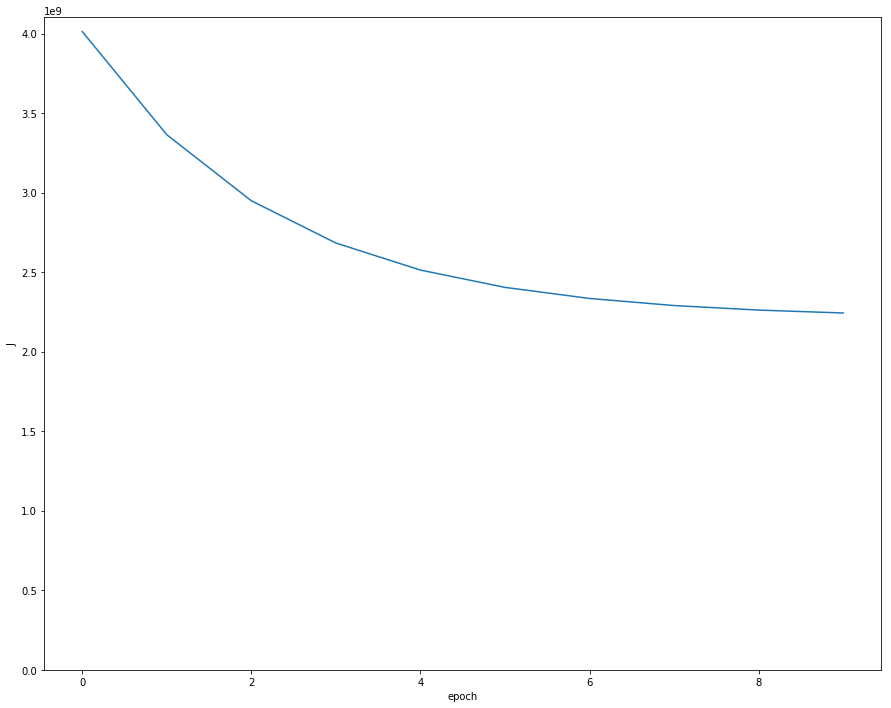

In [290]:
# Params
epochs = 10
alpha = 0.1

# Plotting
x_train, y_train = preprocess(x_train_raw, y_train_raw, scaler, is_train=True)
# x_train[:, 1] *= 3
fig, ax = plot_loss(x_train, y_train)
Js = []

# Gradient descent
w = np.random.randn(2,1)
w_old = w.copy()
for epoch in range(epochs):
    
    J = loss(x_train, y_train, w)
    grad_w = grad(x_train, y_train, w)
    w -= alpha * grad_w
    
    # Plotting
    w0, w1 = zip(w_old.ravel(), w.ravel())
    ax.plot(w0, w1, "bx-")
    w_old = w.copy()
    Js.append(J)
    
# Plotting
plt.figure()
plt.plot(Js)
plt.xlabel("epoch")
plt.ylabel("J")
plt.ylim(0, None)



- basic gradinet descent
- unscaled
- ladění alpha

# Minibatch gradinet descent
- GD vyžaduje pro jeden krok spočítat všechny predikce -> výpočetně náročný
- můžeme spočítat gradient jen z několika predikcí

In [301]:
# create batch iterator 
def iter_batches(x, y, batch_size):
    start = 0
    while start < x.shape[0]:
        x_batch = x[start:start+batch_size,...]
        y_batch = y[start:start+batch_size,...]
        yield x_batch, y_batch
        
        start += batch_size 

(0, 4103147367.153526)

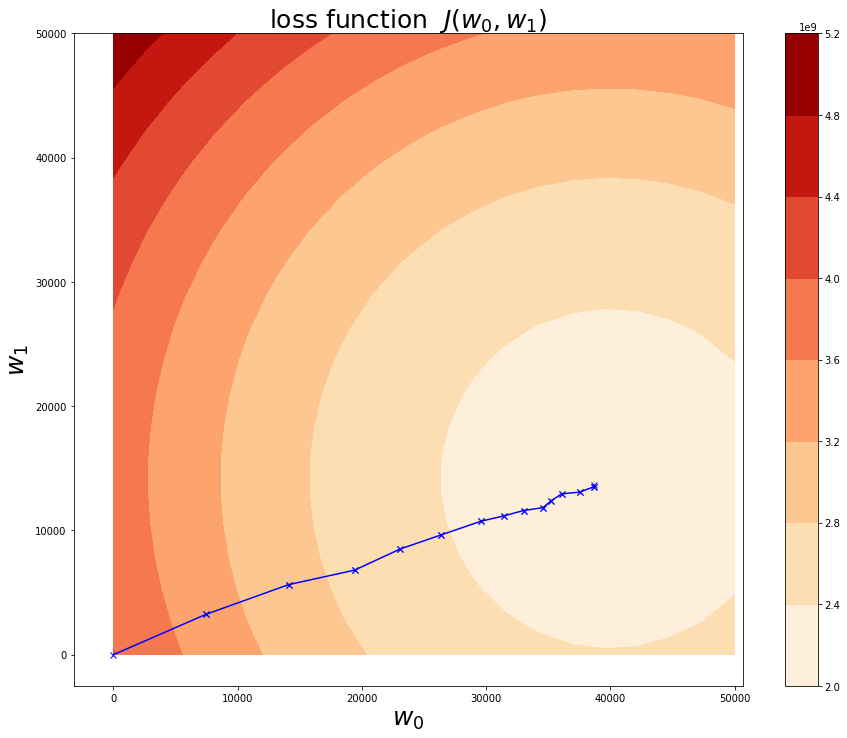

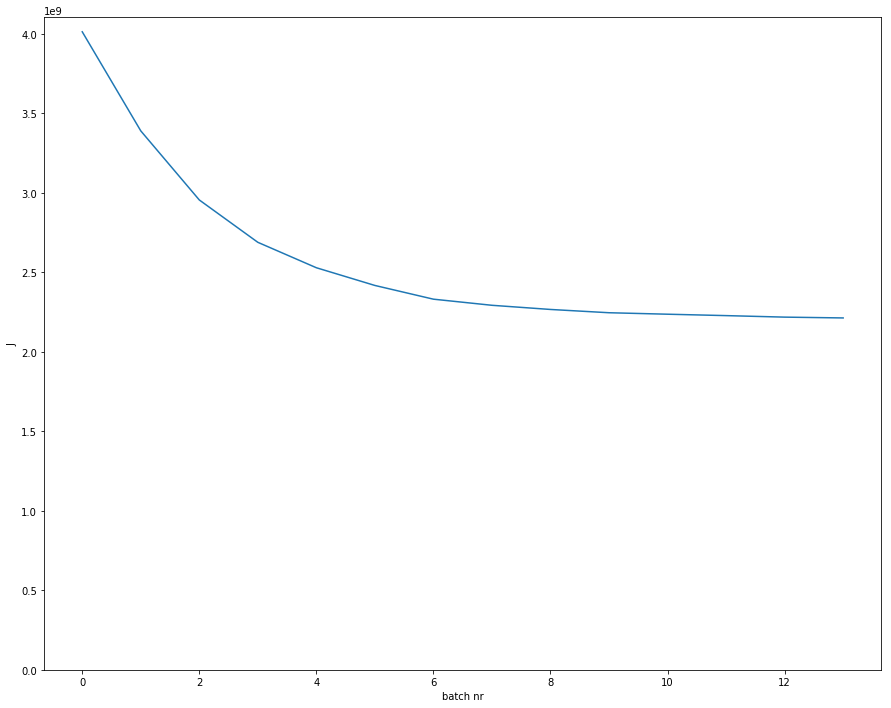

In [320]:
# Params
epochs = 1
alpha = 0.1
batch_size = 512

# Plotting
x_train, y_train = preprocess(x_train_raw, y_train_raw, scaler, is_train=True)
# x_train[:, 1] *= 3
fig, ax = plot_loss(x_train, y_train)
Js = []

# Gradient descent
w = np.random.randn(2,1)
w_old = w.copy()
for epoch in range(epochs):
    for x_batch, y_batch in iter_batches(x_train, y_train, batch_size):
    
        J = loss(x_train, y_train, w)
        grad_w = grad(x_batch, y_batch, w)
        w -= alpha * grad_w

        # Plotting
        w0, w1 = zip(w_old.ravel(), w.ravel())
        ax.plot(w0, w1, "bx-")
        w_old = w.copy()
        Js.append(J)
    
# Plotting
plt.figure()
plt.plot(Js)
plt.xlabel("batch nr")
plt.ylabel("J")
plt.ylim(0, None)



- ne uplně rovný průběh (je to aproximace)
- vyzkoušet různé velikosti batche
- dostaneme se do minima během jedné epochy
- loss zde počítám z celé sady (kvůli zobrazení), typicky bych vypisoval/vykresloval po epoše
- je dobré při každé epoše zamíchat trainset

# Poznámky k gradient descent
- Můžeme použít i na jiné modely?
- Co se změní?
- Jsem v globálním minimu. Mám nejlepší možný prediktor?
- Regularizace jindy
- Používá se pro trénování neuronových sítí
- Další varianty
  - stochastic gradient descent (minibatch_size = 1)
  - SGD + momentum - pokud jsou lokální minima
  - ADAM
  - a další

# Logistic regression
- binární klasifikátor
- princip stejný, regressor obalený sigmoidou, změněná loss funkce
- Detaily v knize *Hands-On Machine Learning with Scikit-Learn and TensorFlow*

# TODO

- změny logistic regression -> predikce, loss funkce, softmax
- plot \hat{y} = f(x_1)
